## Part 2: For a Sigmoid network:
### A. Plot the loss functions for vanilla_sgd, sgd_w_reg, sgd_w_momentum, sgd_w_reg_momentum_drop_out or the default parameters.

In [1]:
##########################
#   Importing libraries  #
##########################
import numpy as np
import pandas as pd
from matplotlib import pyplot as py
import time

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Generate some training    #
#      data from a GMM        #
###############################
def gen_gmm_data(n = 999, plot=False):
    # Fixing seed for repeatability
    np.random.seed(123)
    
    # Parameters of a normal distribuion
    mean_1 = [0, 2] ; mean_2 = [2, -2] ; mean_3 = [-2, -2]
    mean = [mean_1, mean_2, mean_3] ; cov = [[1, 0], [0, 1]]  
    
    # Setting up the class probabilities
    n_samples = n
    pr_class_1 = pr_class_2 = pr_class_3 = 1/3.0
    n_class = (n_samples * np.array([pr_class_1,pr_class_2, pr_class_3])).astype(int)
  
    # Generate sample data
    for i in range(3):
        x1,x2 = np.random.multivariate_normal(mean[i], cov, n_class[i]).T
        if (i==0):
            xs = np.array([x1,x2])
            cl = np.array([n_class[i]*[i]])
        else: 
            xs_new = np.array([x1,x2])
            cl_new = np.array([n_class[i]*[i]])
            xs = np.concatenate((xs, xs_new), axis = 1)
            cl = np.concatenate((cl, cl_new), axis = 1)
    
    # Plot?
    if plot:
        py.scatter(xs[:1,:],xs[1:,:], c = cl)

    # One hot encoding classes
    y = pd.Series(cl[0].tolist())
    y = pd.get_dummies(y).as_matrix() 

    # Normalizing data (prevents overflow errors)     
    mu = xs.mean(axis = 1)
    std = xs.std(axis = 1)
    xs = (xs.T - mu) / std
    
    return xs, y, cl

###############

#%%%%%%%%%%%%%%%%%%%%%%%
#    Hidden Units     #
#######################
ReLU = np.vectorize(lambda z: np.fmax(0,z))
sigmoid = lambda z: 1 / (1 + np.exp(-z))
softmax = lambda z: np.exp(z)/(np.sum(np.exp(z),axis=1))[:,np.newaxis]

# %%%%%%%%%%%%%%%%%%%%%
#  Utility Functions  #
# #####################
def predict(Y_hat):
    return np.argmax(Y_hat, axis=1)


def error_rate(Y_hat, cl):
    prediction = predict(Y_hat)
    return np.mean(prediction != cl)


def cost(Y_hat, Y):
    tot = Y * np.log(Y_hat)
    return -tot.sum()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   1- Hidden Layer Sigmoid Network   #
####################################
def forward(X,parameters, drop_out = 1):
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    
    # Forward pass
    a1 = X.dot(W) + b1
    #H = ReLU(a1) * drop_out
    H = sigmoid(a1) * drop_out
    a2 = H.dot(V) + b2
    Y_hat = softmax(a2)
    return H,Y_hat

#%%%%%%%%%%%%%%%
#   Gradient   #
################

def grad(X,H,Y,Y_hat,parameters):  
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    # Gradients - ReLU
    dV = H.T.dot(Y_hat - Y)
    db2 = (Y_hat - Y).sum(axis=0)
    
    #dW = X.T.dot(((Y_hat - Y).dot(V.T) * (H > 0))) 
    #db1 = ((Y_hat - Y).dot(V.T) * (H > 0)).sum(axis=0)
    
    # Gradients - sigmoid
    dW = X.T.dot((Y_hat-Y).dot(V) * (H * (1 - H)))
    db1 = (Y_hat-Y).dot(V) * (H * (1 - H)).sum(axis=0)
    
    
    #return {'dV':dV,'db2':db2,'dW':dW,'db1':db1}
    return dW,db1,dV,db2

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Parameter Update: Momentum + Regularization   #
###################################################
def parameter_update(parameters,  grads, 
                     momentum_params = [0,0,0,0], 
                     lr = 1, reg = 0, alpha = 0):
    # Unpacking parameters            
    W,b1,V,b2 = parameters
    dW,db1,dV,db2 = grads
    vW,vb1,vV,vb2 = momentum_params
    
    # Momentum update
    vW  = alpha * vW -  lr * (dW + reg*W)
    vb1 = alpha * vb1 - lr * (db1 + reg*b1)
    vV  = alpha * vV -  lr * (dV + reg*V)
    vb2 = alpha * vb2 - lr * (db2 + reg*b2)
    momentum_params = [vW,vb1,vV,vb2] 
    
    # Parameter updates
    W  = W  + vW
    b1 = b1 + vb1
    V  = V  + vV
    b2 = b2 + vb2
    parameters =[W,b1,V,b2]

             
    return parameters, momentum_params

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#  Generate data for network    #
#################################
X, Y, cl = gen_gmm_data()

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#      Building the model     #
###############################
def run_model(X, Y, cl,
              nodes_in_hidden_layer = 3,
              num_dim = 2,     # <- number of dimensions here it is 2: x1,x2
              num_classes = 3, # <- number of classes in the problem
              iterations = 1000,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False):    

    
    ###################################
    #   Initial values for network    #
    ###################################
    # Intialize weights
    np.random.seed(123)
    W = np.random.randn(num_dim * nodes_in_hidden_layer).reshape(num_dim,nodes_in_hidden_layer)
    b1 = 0
    V = np.random.randn(num_classes * nodes_in_hidden_layer).reshape(nodes_in_hidden_layer,num_classes)
    b2 = 0
    parameters = [W,b1,V,b2]
    
    
    # Hyperparameters 
    lr = 0.0001 # learning rate
    reg = 0.01 * regularization_include
    
    # Momentum parameters
    alpha = 0.9 * momentum_include
    vV = 0
    vb2 = 0
    vW = 0
    vb1 = 0
    momentum_params = [vW,vb1,vV,vb2]    
    
    # Place holder for losses
    losses = []
    errors = []    
   
    ###################
    #   Run the model #
    ###################
    for i in range(0,iterations):
        # -- Drop Out Mask --
        # When !=1 then ddrop rate is 12.5%  (~0.5/4 = 12.5%)
        # Short cut to include drop_out 
        drop_out =  (1 - drop_out_include) + drop_out_include * np.round(1-np.random.rand(nodes_in_hidden_layer)/4) 
        
        # -- Forward propoagation --
        H,Y_hat = forward(X,parameters,drop_out)
        
        # -- Backward propagation --
        # Gradient calculation
        grads_in = grad(X,H,Y,Y_hat,parameters)
        # Parameter update
        new_params, new_mom_param = parameter_update(parameters, grads_in, 
                             momentum_params, alpha = alpha, 
                             lr = lr, reg = reg)
        
        # -- Updating values --
        H,Y_hat = forward(X,new_params, drop_out)
        parameters = new_params
        momentum_params = new_mom_param
        # Prediction and Error rate            
        errs_i = error_rate(Y_hat, cl) ; errors.append(errs_i)
        loss_i = cost(Y_hat, Y); losses.append(loss_i)
        if ((i % 25) == 0):    
            print(
            '''
            ---- Iteration {i} ----
            Error rate : {er}
            Loss: {loss}
            '''.format(i= i, er = errs_i, loss = loss_i))
    return {"errors":errs_i, "loss":losses, "parameters":parameters}


            ---- Iteration 0 ----
            Error rate : 0.36536536536536535
            Loss: 815.5770638412325
            

            ---- Iteration 25 ----
            Error rate : 0.15315315315315314
            Loss: 567.097113716236
            

            ---- Iteration 50 ----
            Error rate : 0.01901901901901902
            Loss: 469.01670271879595
            

            ---- Iteration 75 ----
            Error rate : 0.005005005005005005
            Loss: 387.8344540999427
            


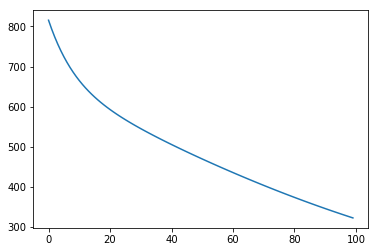

In [2]:
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False)
%matplotlib inline
py.plot(vanilla_sgd['loss'])


            ---- Iteration 0 ----
            Error rate : 0.36536536536536535
            Loss: 815.5771341691316
            

            ---- Iteration 25 ----
            Error rate : 0.15315315315315314
            Loss: 567.1073790261585
            

            ---- Iteration 50 ----
            Error rate : 0.01901901901901902
            Loss: 469.0381060873975
            

            ---- Iteration 75 ----
            Error rate : 0.005005005005005005
            Loss: 387.86498577001777
            


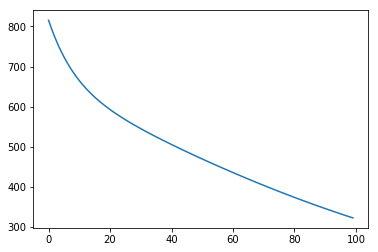

In [3]:
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)
%matplotlib inline
py.plot(sgd_w_reg['loss'])


            ---- Iteration 0 ----
            Error rate : 0.36536536536536535
            Loss: 815.5771341691316
            

            ---- Iteration 25 ----
            Error rate : 0.0
            Loss: 170.6121665454524
            

            ---- Iteration 50 ----
            Error rate : 0.0
            Loss: 42.28903908786346
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 24.447415179902322
            


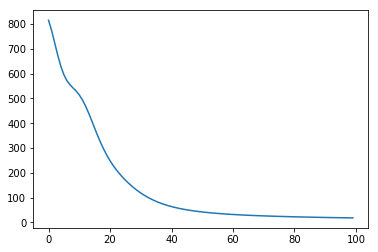

In [4]:
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)
%matplotlib inline
py.plot(sgd_w_reg_momentum['loss'])


            ---- Iteration 0 ----
            Error rate : 0.36536536536536535
            Loss: 815.5771341691316
            

            ---- Iteration 25 ----
            Error rate : 0.0
            Loss: 170.6121665454524
            

            ---- Iteration 50 ----
            Error rate : 0.0
            Loss: 42.28903908786346
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 24.447415179902322
            


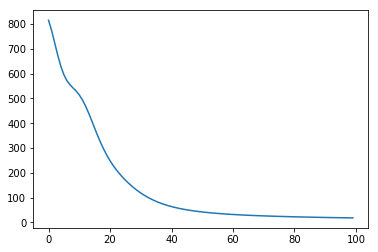

In [5]:
sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True) 
%matplotlib inline
py.plot(sgd_w_reg_momentum_drop_out['loss'])

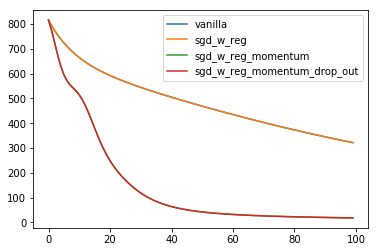

In [6]:
%matplotlib inline
py.plot(vanilla_sgd['loss'],label='vanilla')
py.plot(sgd_w_reg['loss'],label='sgd_w_reg')
py.plot(sgd_w_reg_momentum['loss'],label='sgd_w_reg_momentum')
py.plot(sgd_w_reg_momentum_drop_out['loss'],label='sgd_w_reg_momentum_drop_out')
py.legend(loc="upper right")



sgd_w_reg_momentum and sgd_w_reg_momentum_drop_out have better performances than the other two schemes. Because loss decreases quicky in the first 40 iterations for these regularization schemes, and loss are lower in each iteration. 

### b - Repeate 1.1 with nodes_in_hidden_layer=5

In [7]:
##########################
#   Importing libraries  #
##########################
import numpy as np
import pandas as pd
from matplotlib import pyplot as py
import time

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Generate some training    #
#      data from a GMM        #
###############################
def gen_gmm_data(n = 999, plot=False):
    # Fixing seed for repeatability
    np.random.seed(123)
    
    # Parameters of a normal distribuion
    mean_1 = [0, 2] ; mean_2 = [2, -2] ; mean_3 = [-2, -2]
    mean = [mean_1, mean_2, mean_3] ; cov = [[1, 0], [0, 1]]  
    
    # Setting up the class probabilities
    n_samples = n
    pr_class_1 = pr_class_2 = pr_class_3 = 1/3.0
    n_class = (n_samples * np.array([pr_class_1,pr_class_2, pr_class_3])).astype(int)
  
    # Generate sample data
    for i in range(3):
        x1,x2 = np.random.multivariate_normal(mean[i], cov, n_class[i]).T
        if (i==0):
            xs = np.array([x1,x2])
            cl = np.array([n_class[i]*[i]])
        else: 
            xs_new = np.array([x1,x2])
            cl_new = np.array([n_class[i]*[i]])
            xs = np.concatenate((xs, xs_new), axis = 1)
            cl = np.concatenate((cl, cl_new), axis = 1)
    
    # Plot?
    if plot:
        py.scatter(xs[:1,:],xs[1:,:], c = cl)

    # One hot encoding classes
    y = pd.Series(cl[0].tolist())
    y = pd.get_dummies(y).as_matrix() 

    # Normalizing data (prevents overflow errors)     
    mu = xs.mean(axis = 1)
    std = xs.std(axis = 1)
    xs = (xs.T - mu) / std
    
    return xs, y, cl

###############

#%%%%%%%%%%%%%%%%%%%%%%%
#    Hidden Units     #
#######################
ReLU = np.vectorize(lambda z: np.fmax(0,z))
sigmoid = np.vectorize(lambda z: 1 / (1 + np.exp(-z)))
softmax = lambda z: np.exp(z)/(np.sum(np.exp(z),axis=1))[:,np.newaxis]

# %%%%%%%%%%%%%%%%%%%%%
#  Utility Functions  #
# #####################
def predict(Y_hat):
    return np.argmax(Y_hat, axis=1)


def error_rate(Y_hat, cl):
    prediction = predict(Y_hat)
    return np.mean(prediction != cl)


def cost(Y_hat, Y):
    tot = Y * np.log(Y_hat)
    return -tot.sum()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   1- Hidden Layer Sigmoid Network   #
####################################
def forward(X,parameters, drop_out = 1):
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    
    # Forward pass
    a1 = X.dot(W) + b1
    #H = ReLU(a1) * drop_out
    H = sigmoid(a1) * drop_out
    a2 = H.dot(V) + b2
    Y_hat = softmax(a2)
    return H,Y_hat

#%%%%%%%%%%%%%%%
#   Gradient   #
################

def grad(X,H,Y,Y_hat,parameters):  
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    # Gradients - ReLU
    dV = H.T.dot(Y_hat - Y)
    db2 = (Y_hat - Y).sum(axis=0)
    
    #dW = X.T.dot(((Y_hat - Y).dot(V.T) * (H > 0))) 
    #db1 = ((Y_hat - Y).dot(V.T) * (H > 0)).sum(axis=0)
    
    # Gradients - sigmoid
    dW = X.T.dot((Y_hat-Y).dot(V.T) * (H * (1 - H)))
    db1 = (Y_hat-Y).dot(V.T) * (H * (1 - H)).sum(axis=0)
    
    
    #return {'dV':dV,'db2':db2,'dW':dW,'db1':db1}
    return dW,db1,dV,db2

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Parameter Update: Momentum + Regularization   #
###################################################
def parameter_update(parameters,  grads, 
                     momentum_params = [0,0,0,0], 
                     lr = 1, reg = 0, alpha = 0):
    # Unpacking parameters            
    W,b1,V,b2 = parameters
    dW,db1,dV,db2 = grads
    vW,vb1,vV,vb2 = momentum_params
    
    # Momentum update
    vW  = alpha * vW -  lr * (dW + reg*W)
    vb1 = alpha * vb1 - lr * (db1 + reg*b1)
    vV  = alpha * vV -  lr * (dV + reg*V)
    vb2 = alpha * vb2 - lr * (db2 + reg*b2)
    momentum_params = [vW,vb1,vV,vb2] 
    
    # Parameter updates
    W  = W  + vW
    b1 = b1 + vb1
    V  = V  + vV
    b2 = b2 + vb2
    parameters =[W,b1,V,b2]

             
    return parameters, momentum_params

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#  Generate data for network    #
#################################
X, Y, cl = gen_gmm_data()

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#      Building the model     #
###############################
def run_model(X, Y, cl,
              nodes_in_hidden_layer = 5,
              num_dim = 2,     # <- number of dimensions here it is 2: x1,x2
              num_classes = 3, # <- number of classes in the problem
              iterations = 1000,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False):    

    
    ###################################
    #   Initial values for network    #
    ###################################
    # Intialize weights
    np.random.seed(123)
    W = np.random.randn(num_dim * nodes_in_hidden_layer).reshape(num_dim,nodes_in_hidden_layer)
    b1 = 0
    V = np.random.randn(num_classes * nodes_in_hidden_layer).reshape(nodes_in_hidden_layer,num_classes)
    b2 = 0
    parameters = [W,b1,V,b2]
    
    
    # Hyperparameters 
    lr = 0.0001 # learning rate
    reg = 0.01 * regularization_include
    
    # Momentum parameters
    alpha = 0.9 * momentum_include
    vV = 0
    vb2 = 0
    vW = 0
    vb1 = 0
    momentum_params = [vW,vb1,vV,vb2]    
    
    # Place holder for losses
    losses = []
    errors = []    
   
    ###################
    #   Run the model #
    ###################
    for i in range(0,iterations):
        # -- Drop Out Mask --
        # When !=1 then ddrop rate is 12.5%  (~0.5/4 = 12.5%)
        # Short cut to include drop_out 
        drop_out =  (1 - drop_out_include) + drop_out_include * np.round(1-np.random.rand(nodes_in_hidden_layer)/4) 
        
        # -- Forward propoagation --
        H,Y_hat = forward(X,parameters,drop_out)
        
        # -- Backward propagation --
        # Gradient calculation
        grads_in = grad(X,H,Y,Y_hat,parameters)
        # Parameter update
        new_params, new_mom_param = parameter_update(parameters, grads_in, 
                             momentum_params, alpha = alpha, 
                             lr = lr, reg = reg)
        
        # -- Updating values --
        H,Y_hat = forward(X,new_params, drop_out)
        parameters = new_params
        momentum_params = new_mom_param
        # Prediction and Error rate            
        errs_i = error_rate(Y_hat, cl) ; errors.append(errs_i)
        loss_i = cost(Y_hat, Y); losses.append(loss_i)
        if ((i % 25) == 0):    
            print(
            '''
            ---- Iteration {i} ----
            Error rate : {er}
            Loss: {loss}
            '''.format(i= i, er = errs_i, loss = loss_i))
    return {"errors":errs_i, "loss":losses, "parameters":parameters}


            ---- Iteration 0 ----
            Error rate : 0.6566566566566566
            Loss: 1450.5864416279028
            

            ---- Iteration 25 ----
            Error rate : 0.3113113113113113
            Loss: 744.7528054802333
            

            ---- Iteration 50 ----
            Error rate : 0.004004004004004004
            Loss: 478.7947491808475
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 340.58028230286243
            


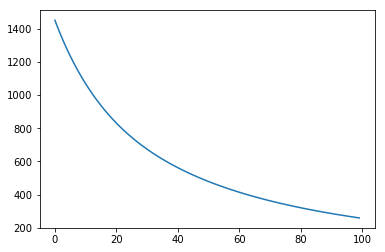

In [8]:
vanilla_sgd = run_model(X,Y,cl, iterations = 100,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False)
%matplotlib inline
py.plot(vanilla_sgd['loss'])


            ---- Iteration 0 ----
            Error rate : 0.6566566566566566
            Loss: 1450.5855664869064
            

            ---- Iteration 25 ----
            Error rate : 0.3113113113113113
            Loss: 744.7595116809231
            

            ---- Iteration 50 ----
            Error rate : 0.004004004004004004
            Loss: 478.8169756302764
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 340.61070552448325
            


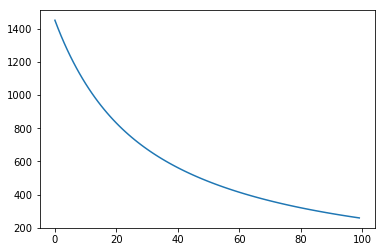

In [9]:
sgd_w_reg = run_model(X,Y,cl, iterations = 100,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)
%matplotlib inline
py.plot(sgd_w_reg['loss'])


            ---- Iteration 0 ----
            Error rate : 0.6566566566566566
            Loss: 1450.5855664869064
            

            ---- Iteration 25 ----
            Error rate : 0.0
            Loss: 118.12511847666819
            

            ---- Iteration 50 ----
            Error rate : 0.0
            Loss: 26.004028169140685
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 15.878006619973021
            


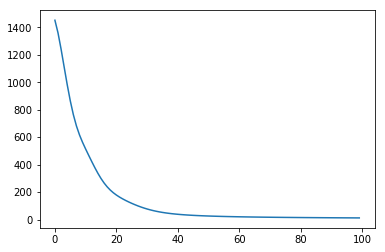

In [10]:
sgd_w_reg_momentum = run_model(X,Y,cl, iterations = 100,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)
%matplotlib inline
py.plot(sgd_w_reg_momentum['loss'])


            ---- Iteration 0 ----
            Error rate : 0.6566566566566566
            Loss: 1450.5855664869064
            

            ---- Iteration 25 ----
            Error rate : 0.0
            Loss: 118.12511847666819
            

            ---- Iteration 50 ----
            Error rate : 0.0
            Loss: 26.004028169140685
            

            ---- Iteration 75 ----
            Error rate : 0.0
            Loss: 15.878006619973021
            


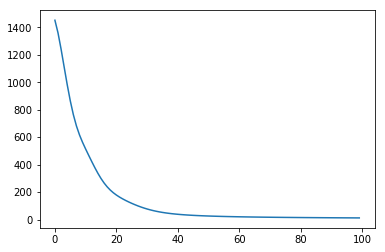

In [11]:
sgd_w_reg_momentum_drop_out = run_model(X,Y,cl, iterations = 100,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True) 
%matplotlib inline
py.plot(sgd_w_reg_momentum_drop_out['loss'])

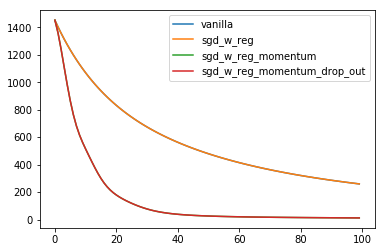

In [12]:
%matplotlib inline
py.plot(vanilla_sgd['loss'],label='vanilla')
py.plot(sgd_w_reg['loss'],label='sgd_w_reg')
py.plot(sgd_w_reg_momentum['loss'],label='sgd_w_reg_momentum')
py.plot(sgd_w_reg_momentum_drop_out['loss'],label='sgd_w_reg_momentum_drop_out')
py.legend(loc="upper right")



Same as before, sgd_w_reg_momentum and sgd_w_reg_momentum_drop_out have better performances than the other two schemes. Because loss decreases quicky in the first 20 iterations for these regularization schemes, and loss are lower in each iteration.  
  
It performs worse than when nodes in hidden layer is 3. Because loss are in genral higher for same iterations and loss doesn't decrease monotonically as iteration increases. 


### – C. Repeat 1.1 however now include the timeit function to measure the amount of time it takes to execute the code using the default parameters. How long does it take each one of the fitting schemes to run? Display your results as a table.

In [13]:
##########################
#   Importing libraries  #
##########################
import numpy as np
import pandas as pd
from matplotlib import pyplot as py
import time

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Generate some training    #
#      data from a GMM        #
###############################
def gen_gmm_data(n = 999, plot=False):
    # Fixing seed for repeatability
    np.random.seed(123)
    
    # Parameters of a normal distribuion
    mean_1 = [0, 2] ; mean_2 = [2, -2] ; mean_3 = [-2, -2]
    mean = [mean_1, mean_2, mean_3] ; cov = [[1, 0], [0, 1]]  
    
    # Setting up the class probabilities
    n_samples = n
    pr_class_1 = pr_class_2 = pr_class_3 = 1/3.0
    n_class = (n_samples * np.array([pr_class_1,pr_class_2, pr_class_3])).astype(int)
  
    # Generate sample data
    for i in range(3):
        x1,x2 = np.random.multivariate_normal(mean[i], cov, n_class[i]).T
        if (i==0):
            xs = np.array([x1,x2])
            cl = np.array([n_class[i]*[i]])
        else: 
            xs_new = np.array([x1,x2])
            cl_new = np.array([n_class[i]*[i]])
            xs = np.concatenate((xs, xs_new), axis = 1)
            cl = np.concatenate((cl, cl_new), axis = 1)
    
    # Plot?
    if plot:
        py.scatter(xs[:1,:],xs[1:,:], c = cl)

    # One hot encoding classes
    y = pd.Series(cl[0].tolist())
    y = pd.get_dummies(y).as_matrix() 

    # Normalizing data (prevents overflow errors)     
    mu = xs.mean(axis = 1)
    std = xs.std(axis = 1)
    xs = (xs.T - mu) / std
    
    return xs, y, cl


#%%%%%%%%%%%%%%%%%%%%%%%
#    Hidden Units     #
#######################
ReLU = np.vectorize(lambda z: np.fmax(0,z))
sigmoid = lambda z: 1 / (1 + np.exp(-z))
softmax = lambda z: np.exp(z)/(np.sum(np.exp(z),axis=1))[:,np.newaxis]

# %%%%%%%%%%%%%%%%%%%%%
#  Utility Functions  #
# #####################
def predict(Y_hat):
    return np.argmax(Y_hat, axis=1)


def error_rate(Y_hat, cl):
    prediction = predict(Y_hat)
    return np.mean(prediction != cl)


def cost(Y_hat, Y):
    tot = Y * np.log(Y_hat)
    return -tot.sum()

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   1- Hidden Layer ReLU Network   #
####################################
def forward(X,parameters, drop_out = 1):
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    
    # Forward pass
    a1 = X.dot(W) + b1
    #H = ReLU(a1) * drop_out
    H = sigmoid(a1) * drop_out
    a2 = H.dot(V) + b2
    Y_hat = softmax(a2)
    return H,Y_hat

#%%%%%%%%%%%%%%%
#   Gradient   #
################

def grad(X,H,Y,Y_hat,parameters):  
    # Unpacking parameters    
    W,b1,V,b2 = parameters
    # Gradients - ReLU
    dV = H.T.dot(Y_hat - Y)
    db2 = (Y_hat - Y).sum(axis=0)
    #dW = X.T.dot(((Y_hat - Y).dot(V.T) * (H > 0))) 
    #db1 = ((Y_hat - Y).dot(V.T) * (H > 0)).sum(axis=0)
    
    # Gradients - sigmoid
    dW = X.T.dot((Y_hat-Y).dot(V) * (H * (1 - H)))
    db1 = (Y_hat-Y).dot(V) * (H * (1 - H)).sum(axis=0)
    
    
    #return {'dV':dV,'db2':db2,'dW':dW,'db1':db1}
    return dW,db1,dV,db2

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#   Parameter Update: Momentum + Regularization   #
###################################################
def parameter_update(parameters,  grads, 
                     momentum_params = [0,0,0,0], 
                     lr = 1, reg = 0, alpha = 0):
    # Unpacking parameters            
    W,b1,V,b2 = parameters
    dW,db1,dV,db2 = grads
    vW,vb1,vV,vb2 = momentum_params
    
    # Momentum update
    vW  = alpha * vW -  lr * (dW + reg*W)
    vb1 = alpha * vb1 - lr * (db1 + reg*b1)
    vV  = alpha * vV -  lr * (dV + reg*V)
    vb2 = alpha * vb2 - lr * (db2 + reg*b2)
    momentum_params = [vW,vb1,vV,vb2] 
    
    # Parameter updates
    W  = W  + vW
    b1 = b1 + vb1
    V  = V  + vV
    b2 = b2 + vb2
    parameters =[W,b1,V,b2]

             
    return parameters, momentum_params

#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#  Generate data for network    #
#################################
X, Y, cl = gen_gmm_data()

# %%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#      Building the model     #
###############################
def run_model(X, Y, cl,
              nodes_in_hidden_layer = 3,
              num_dim = 2,     # <- number of dimensions here it is 2: x1,x2
              num_classes = 3, # <- number of classes in the problem
              iterations = 1000,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False):    

    
    ###################################
    #   Initial values for network    #
    ###################################
    # Intialize weights
    np.random.seed(123)
    W = np.random.randn(num_dim * nodes_in_hidden_layer).reshape(num_dim,nodes_in_hidden_layer)
    b1 = 0
    V = np.random.randn(num_classes * nodes_in_hidden_layer).reshape(nodes_in_hidden_layer,num_classes)
    b2 = 0
    parameters = [W,b1,V,b2]
    
    
    # Hyperparameters 
    lr = 0.0001 # learning rate
    reg = 0.01 * regularization_include
    
    # Momentum parameters
    alpha = 0.9 * momentum_include
    vV = 0
    vb2 = 0
    vW = 0
    vb1 = 0
    momentum_params = [vW,vb1,vV,vb2]    
    
    # Place holder for losses
    losses = []
    errors = []    
   
    ###################
    #   Run the model #
    ###################
    for i in range(0,iterations):
        # -- Drop Out Mask --
        # When !=1 then ddrop rate is 12.5%  (~0.5/4 = 12.5%)
        # Short cut to include drop_out 
        drop_out =  (1 - drop_out_include) + drop_out_include * np.round(1-np.random.rand(nodes_in_hidden_layer)/4) 
        
        # -- Forward propoagation --
        H,Y_hat = forward(X,parameters,drop_out)
        
        # -- Backward propagation --
        # Gradient calculation
        grads_in = grad(X,H,Y,Y_hat,parameters)
        # Parameter update
        new_params, new_mom_param = parameter_update(parameters, grads_in, 
                             momentum_params, alpha = alpha, 
                             lr = lr, reg = reg)
        
        # -- Updating values --
        H,Y_hat = forward(X,new_params, drop_out)
        parameters = new_params
        momentum_params = new_mom_param
        # Prediction and Error rate            
        errs_i = error_rate(Y_hat, cl) ; errors.append(errs_i)
        loss_i = cost(Y_hat, Y); losses.append(loss_i)
       
    return {"errors":errs_i, "loss":losses, "parameters":parameters}

In [14]:
start_time = time.clock()
run_model(X,Y,cl, iterations = 100,
              regularization_include = False,
              momentum_include = False,
              drop_out_include = False)
vanilla_sgd_time = time.clock() - start_time
vanilla_sgd_time



0.3303463

In [15]:
start_time = time.clock()
run_model(X,Y,cl, iterations = 100,
              regularization_include = True,
              momentum_include = False,
              drop_out_include = False)
sgd_w_reg_time = time.clock() - start_time
sgd_w_reg_time

0.33775750000000004

In [16]:
start_time = time.clock()
run_model(X,Y,cl, iterations = 100,
                              regularization_include = True,
                              momentum_include = True,
                              drop_out_include = False)
sgd_w_reg_momentum_time = time.clock() - start_time
sgd_w_reg_momentum_time

0.4264439000000001

In [17]:
start_time = time.clock()
run_model(X,Y,cl, iterations = 100,
                                      regularization_include = True,
                                      momentum_include = True,
                                      drop_out_include = True)
sgd_w_reg_momentum_drop_out_time = time.clock() - start_time
sgd_w_reg_momentum_drop_out_time

0.4412556000000001

In [18]:
import pandas as pd

 
# list of strings
scheme = ['vanilla_sgd','sgd_w_reg','sgd_w_momentum','sgd_w_reg_momentum_drop_out']
time = [vanilla_sgd_time,sgd_w_reg_time,sgd_w_reg_momentum_time,sgd_w_reg_momentum_drop_out_time]
 
# Calling DataFrame constructor on list
df = pd.DataFrame(scheme, time)
print(df)


                                    0
0.330346                  vanilla_sgd
0.337758                    sgd_w_reg
0.426444               sgd_w_momentum
0.441256  sgd_w_reg_momentum_drop_out


### – D. Compare the performance of a ReLu network to a sigmoid network based on

#### a. The regularization scheme with default parameters

ReLu with 3 nodes in hidden layer

!['ReLu with 3-layer hidden nodes'](ReLu_3layer.PNG)

Sigmoid with 3 nodes in hidden layer

!['sigmoid with 3-layer hidden nodes'](sigmoid_3layer.PNG)

ReLu has better performance as loss is lower for all regularization scheme.  

#### b. nodes_in_hidden_layer=5

ReLu with 5 nodes in hidden layer

!['ReLu with 5-layer hidden nodes'](ReLu_5layer.PNG)

sigmoid with 5 nodes in hidden layer

!['sigmoid with 5-layer hidden nodes'](sigmoid_5layer.PNG)

When there are 5 nodes in hidden layer, sigmoid has better performance as loss is lower for all regularization scheme.  

#### c. Length of time required to run and fit the model

Tables for sigmoid & ReLu 's running time are below respectively

!['sigmoid_time'](sigmoide_time.PNG)
!['ReLu_time'](ReLu_time.PNG)

When nodes in the hidden layer is 3, sigmoid runs faster than ReLu as activation function.  